<a href="https://colab.research.google.com/github/mariemomar/EmoDetect/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-song-audio")

print("Path to dataset files:", path)

100%|██████████| 456M/456M [00:06<00:00, 78.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1


In [3]:
actors_folders = [os.path.join(path, folder) for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
# Debugging: List all actor folders
print("Actor folders found:", actors_folders)

# Collect all audio file paths
audio_files = []
for actor_folder in actors_folders:
    for f in os.listdir(actor_folder):
        if f.endswith('.wav'):  # Ensure it's an audio file
            audio_files.append(os.path.join(actor_folder, f))

print("Found audio files:", len(audio_files))

Actor folders found: ['/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_04', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_16', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_10', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_08', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/audio_song_actors_01-24', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_01', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_13', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_09', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_24', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_03', '/r

In [4]:
for audio_file in audio_files:
    # Load the specific audio file
    #y will contain the amplitude values of the audio signal, and sr will contain the sampling rate of the audio ex4000hz
    y, sr = librosa.load(audio_file, sr=None)

    # Apply noise reduction
    y_without_noise = librosa.effects.preemphasis(y)

    # Apply normalization
    y_normalized = librosa.util.normalize(y)

    # For debugging, you can print the file being processed
    # print(f"Processed {audio_file} with sampling rate {sr}")

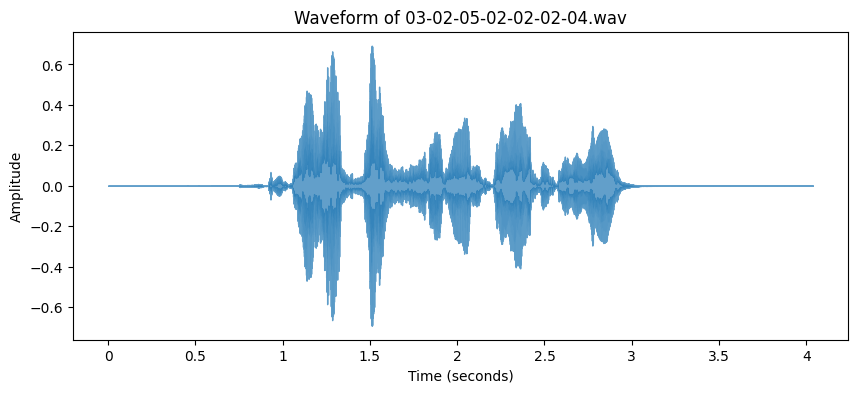

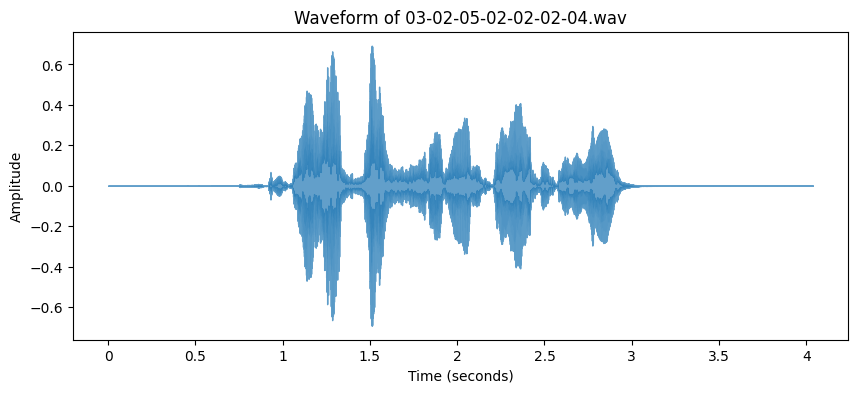

In [5]:
def plot_waveform(file_path):
    y, sr = librosa.load(file_path, sr=None)

    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr, alpha=0.7)
    plt.title(f"Waveform of {os.path.basename(file_path)}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()

# Example: Plot a calm and angry audio sample
calm_audio = [f for f in audio_files if "-02-" in f][0] #calm sample
angry_audio = [f for f in audio_files if "-05-" in f][0]  #angry sample

plot_waveform(calm_audio)
plot_waveform(angry_audio)

In [6]:
def get_label(file_path):
    """Extract emotion label from filename"""
    file_name = os.path.basename(file_path)
    emotion_id = int(file_name.split("-")[2])  # Extracting the XX part (emotion)

    if emotion_id == 2:
        return 0  # Calm
    elif emotion_id == 5:
        return 1  # Angry
    else:
        return None  # Ignore other emotions

In [7]:
def extract_features(y, sr):
    # Extract features: MFCC, spectral centroid, spectral rolloff, and zero-crossing rate
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1) #They are derived by applying a Fourier transform on the audio signal and capture quality of sound
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean() #brightness of a sound. A higher spectral centroid means the sound has more high-frequency components
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean() #It can help distinguish between harmonic and non-harmonic (noisy) content.
    zcr = librosa.feature.zero_crossing_rate(y).mean() #it distinguishes between voiced sounds (like vowels) have low zero-crossing rates and unvoiced sounds tend to have higher zero-crossing rates.

    return np.hstack([mfccs, spectral_centroid, spectral_rolloff, zcr])

In [8]:
def prepare_dataset(file_paths):
    X = []
    y = []

    for file_path in file_paths:
        label = get_label(file_path)

        if label is None:  # Skip files that are not Angry or Calm
            continue

        y_signal, sr = librosa.load(file_path, sr=None)
        features = extract_features(y_signal, sr)

        X.append(features)
        y.append(label)

    return np.array(X), np.array(y)

In [9]:
X, y = prepare_dataset(audio_files)
print(f"Total samples: {len(X)}")
print(f"Feature shape: {X.shape}")
print(f"Class distribution: {np.bincount(y)}")  # Count occurrences of each class

Total samples: 368
Feature shape: (368, 16)
Class distribution: [184 184]


In [28]:
class gnb:
    def __init__(self):
        self.prior = None
        self.n_class = None
        self.mean = None
        self.variance = None
        self.classes = None

    def fit(self, X, y):
        X_df = pd.DataFrame(X)  # Convert NumPy array to DataFrame
        self.mean = X_df.groupby(by=y).mean().values
        self.variance = X_df.groupby(by=y).var().values
        self.n_class = len(np.unique(y))
        self.classes = np.unique(y)
        self.prior = 1 / self.n_class  # Equal priors assumed
        return self

    def gnb_base(self, x_val, x_mean, x_var):
        pi = np.pi
        e = np.e
        eq_1 = 1 / (np.sqrt(2 * pi * x_var))
        exp_term = np.exp(-((x_val - x_mean) ** 2) / (2 * x_var))
        return eq_1 * exp_term

    def predict(self, X):
        X = np.array(X)  # Ensure input is a NumPy array
        split_class = np.array(self.mean), np.array(self.variance)

        predictions = []
        for sample in X:  # Iterate over test samples
            prob_classes = []
            for i in range(self.n_class):
                mean_class, var_class = split_class[0][i], split_class[1][i]
                likelihood = np.prod([self.gnb_base(sample[j], mean_class[j], var_class[j]) for j in range(len(sample))])
                prob_classes.append(likelihood * self.prior)
            predictions.append(self.classes[np.argmax(prob_classes)])  # Select class with max probability
        return np.array(predictions)

In [29]:
X, y = prepare_dataset(audio_files)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes model
model_gnb = gnb()
model_gnb.fit(X_train, y_train)

# Predict
y_pred = model_gnb.predict(X_test)

# Accuracy & Metrics
accuracy = np.mean(y_pred == y_test)
print(f"Model Accuracy: {accuracy:.2f}")

# Precision, Recall, F1-Score
print("Classification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89        34
           1       0.88      0.95      0.92        40

    accuracy                           0.91        74
   macro avg       0.91      0.90      0.90        74
weighted avg       0.91      0.91      0.90        74



# Logistic Regression without Bagging



In [43]:
import numpy as np

class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=700):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):

        return 1 / (1 + np.exp(-z))

    def find_z(self, X):

        return np.dot(X, self.weights) + self.bias

    def loss(self, y, y_hat):

        N = len(y)
        small_value = 1e-15  # to avoid log(0)
        y_hat = np.clip(y_hat, small_value, 1 - small_value)  # Clip values for stability
        return -(1 / N) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    def fit(self, X, y):

        self.weights = np.zeros((X.shape[1], 1))  # 2-> two features , 1 -> one column
        self.bias = 0
        N = len(y)

        for epoch in range(self.num_iterations):

          i = np.random.randint(N)

          for i in range(N) :

            sample = X[i].reshape(1, X.shape[1])
            label = y[i]

            z = self.find_z(sample)
            y_hat = self.sigmoid(z)

            # backword
            delta_w = (y_hat - label) * sample.T
            delta_b =  (y_hat - label).item()

            # update
            self.weights = self.weights - self.learning_rate * delta_w
            self.bias =self.bias - self.learning_rate * delta_b




    def predict(self, X):

        z = self.find_z(X)
        y_hat = self.sigmoid(z)
        return (y_hat >= 0.5).astype(int)  # Classify as 1 if >= 0.5, else 0

    def predict_proba(self, X):
        """
        Predict probabilities for each class (for logistic regression, this is the probability of class 1).
        """
        z = self._find_z(X)
        return self._sigmoid(z)  # Output probabilities between 0 and 1


In [44]:
# Initialize and train the model
model_LogisticRegression = LogisticRegression(learning_rate=0.01, num_iterations=200)
model_LogisticRegression.fit(X_train, y_train)  # This should store weights and bias in the model

# Make predictions (no need to pass weights and bias - they're stored in the model)
y_pred = model_LogisticRegression.predict(X_test )

# Calculate accuracy
correct = 0
for i in range(len(y_test)):
    if y_pred[i] == y_test[i]:  # You forgot the 'if' statement
        correct += 1

accuracy = (correct / len(y_test)) * 100
print(f"Accuracy: {accuracy:.2f}%")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


<ipython-input-43-3f57ea2996f3>:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 72.97%
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.44      0.60        34
           1       0.67      0.97      0.80        40

    accuracy                           0.73        74
   macro avg       0.80      0.71      0.70        74
weighted avg       0.79      0.73      0.71        74



# Apply Bagging with Naïve Bayes and Logistic Regression

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

def bagging_naive_bayes(X_train, y_train, X_test, number_of_bags):

  n_samples = len(X_train)

  X_train , y_train = shuffle(X_train , y_train , random_state=42)

  predictions = []

  for bag in range(number_of_bags):
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    X_bag = X_train[indices]
    y_bag = y_train[indices]

    model = gnb()
    model.fit(X_bag, y_bag)
    predictions.append(model.predict(X_test))


  predictions = np.array(predictions)



  # print(predictions)  # 10 lists each has 74 value predicted
  final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

  return final_predictions



In [33]:
naive_bayes_bagging_predicted =  bagging_naive_bayes(X_train, y_train, X_test, number_of_bags=10)

# print(naive_bayes_bagging_predicted)

correct = 0
for i in range(len(y_test)):
  if naive_bayes_bagging_predicted[i] == y_test[i]:
    correct += 1

correct = (correct / len(y_test)) * 100
print("aacuracy of bagging in naive bayes : " , correct)

print("Classification Report:\n", classification_report(y_test, naive_bayes_bagging_predicted))


aacuracy of bagging in naive bayes :  90.54054054054053
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89        34
           1       0.88      0.95      0.92        40

    accuracy                           0.91        74
   macro avg       0.91      0.90      0.90        74
weighted avg       0.91      0.91      0.90        74



# Logistic Regression with Bagging

In [34]:
def bagging_logistic_regression(X_train, y_train, X_test, number_of_bags):
    n_samples = len(X_train)
    predictions = []

    for bag in range(number_of_bags):
        # Shuffle and sample with replacement
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        X_bag = X_train[indices]
        y_bag = y_train[indices]

        model = LogisticRegression(learning_rate=0.01, num_iterations=200)
        model.fit(X_bag, y_bag)
        y_pred = model.predict(X_test)
        predictions.append(y_pred)

    predictions = np.array(predictions)
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

    return final_predictions


In [35]:
logistic_regression_bagging_predicted = bagging_logistic_regression(X_train, y_train, X_test, number_of_bags=10)

correct = 0
for i in range(len(y_test)):
    if logistic_regression_bagging_predicted[i] == y_test[i]:
        correct += 1

accuracy = (correct / len(y_test)) * 100
print("Accuracy of bagging in logistic regression:", accuracy)
print("Classification Report:\n", classification_report(y_test, logistic_regression_bagging_predicted))


<ipython-input-30-3f57ea2996f3>:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy of bagging in logistic regression: 82.43243243243244
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80        34
           1       0.81      0.88      0.84        40

    accuracy                           0.82        74
   macro avg       0.83      0.82      0.82        74
weighted avg       0.83      0.82      0.82        74



# start taking the input

In [ ]:
!pip install playsound

In [ ]:
!pip install SpeechRecognition

In [ ]:
!pip install pipwin

In [ ]:
!apt-get install -y portaudio19-dev

!pip install PyAudio


In [22]:
from IPython.display import Audio, display
from google.colab import output
import soundfile as sf

def record_audio(filename='audio.wav', duration=5):
    import IPython.display as ipd
    RECORD = f"""
    const sleep = time => new Promise(resolve => setTimeout(resolve, time))
    const b2text = blob => new Promise(resolve => {{
      const reader = new FileReader()
      reader.onloadend = () => resolve(reader.result)
      reader.readAsDataURL(blob)
    }})

    async function record(duration) {{
      const stream = await navigator.mediaDevices.getUserMedia({{ audio: true }})
      const mediaRecorder = new MediaRecorder(stream)
      const audioChunks = []

      mediaRecorder.addEventListener("dataavailable", event => {{
        audioChunks.push(event.data)
      }})

      mediaRecorder.start()
      await sleep(duration)
      mediaRecorder.stop()

      await new Promise(resolve => mediaRecorder.addEventListener("stop", resolve))
      const audioBlob = new Blob(audioChunks)
      const base64 = await b2text(audioBlob)
      return base64
    }}

    record({duration * 1000}).then(base64 => {{
      google.colab.kernel.invokeFunction('notebook.save_audio', [base64], {{}});
    }})
    """
    display(ipd.Javascript(RECORD))

def save_audio(base64_audio):
    import base64
    audio_bytes = base64.b64decode(base64_audio.split(',')[1])
    with open("audio.wav", "wb") as f:
        f.write(audio_bytes)

output.register_callback('notebook.save_audio', save_audio)
record_audio()


<IPython.core.display.Javascript object>

start recording

In [55]:
record_audio(duration=5)  # Record for 5 seconds


<IPython.core.display.Javascript object>

In [ ]:
from IPython.display import Audio
Audio("audio.wav")

In [57]:
# import speech_recognition as sr
import soundfile as sf
import numpy as np
import librosa

def get_audio_and_predict():


    # Save the audio to a file
    audio_path = "audio.wav"

    # Process the saved audio file with librosa
    y, sr_rate = librosa.load(audio_path, sr=None) # sr is the sound rate
    y = librosa.effects.preemphasis(y)
    y = librosa.util.normalize(y)

    # Extract features
    features = extract_features(y, sr_rate).reshape(1, -1)
    return features




# predict the sound using logistic regression

In [58]:
prediction = model_LogisticRegression.predict(get_audio_and_predict())
emotion = "Calm" if prediction == 0 else "Angry"
print(f"Predicted Emotion: {emotion}")

Predicted Emotion: Angry


<ipython-input-57-cb63eb700ee6>:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr_rate = librosa.load(audio_path, sr=None) # sr is the sound rate
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


# predict the sound using Naive Bayes

In [46]:
prediction = model_gnb.predict(get_audio_and_predict())
emotion = "Calm" if prediction == 0 else "Angry"
print(f"Predicted Emotion: {emotion}")

Predicted Emotion: Angry


<ipython-input-41-cb63eb700ee6>:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr_rate = librosa.load(audio_path, sr=None) # sr is the sound rate
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


# predict using the bagging technique and Naive Bayes

In [48]:
prediction =  bagging_naive_bayes(X_train, y_train, get_audio_and_predict() , number_of_bags=10)
emotion = "Calm" if prediction == 0 else "Angry"
print(f"Predicted Emotion: {emotion}")

Predicted Emotion: Angry


<ipython-input-41-cb63eb700ee6>:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr_rate = librosa.load(audio_path, sr=None) # sr is the sound rate
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


# predict using the bagging technique and Logistic Regression

In [50]:
prediction =  bagging_logistic_regression(X_train, y_train, get_audio_and_predict() , number_of_bags=10)
emotion = "Calm" if prediction == 0 else "Angry"
print(f"Predicted Emotion: {emotion}")

<ipython-input-41-cb63eb700ee6>:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr_rate = librosa.load(audio_path, sr=None) # sr is the sound rate
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-43-3f57ea2996f3>:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Predicted Emotion: Angry
